In [19]:
import numpy as np
import pandas as pd
import seaborn as sns

<div class="alert alert-block alert-warning">
<b>Notes:</b>
<br> - Each cell has its own notes.
<br> - I tried Multi linear regression, Polynomial regression, and random forest regression.
<br> - For some reason, the result we got locally is better than the one we get on Kaggle!
<br> - Some output couldn't reduce the volume (like data.info()).
<br> - I tried several encoding techniques, (one-hot encoding was painful, 
</div>

### First Step: Data Setup

In [20]:
train_dt_path = "../data/train.csv"
test_dt_path = "../data/test.csv"

data = pd.read_csv(train_dt_path)
testing_data = pd.read_csv(test_dt_path)

In [21]:
# data.describe()

In [22]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [23]:
testing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

### Second Step: Feature processing ( remove Empty features, populate Nan Values,Encode, Scale)

- Here I removed the features that have more than 50% values of NaN.  
- I removed Id, Utilities & FireplaceQu, because they have only one value for all the feature and because Id is not needed in the prediction process.  
- I am preparing the train set and the test set together so I could use test_set on Kaggle submission.

In [24]:
Y = data['SalePrice']
X = data.drop(['SalePrice'], axis =1)

perc = 50.0
min_count =  int(((100-perc)/100)*X.shape[0] + 1)
print(min_count)
X.dropna( axis=1,
                thresh=min_count, inplace=True)
testing_data.dropna(axis=1,
                thresh=min_count, inplace=True)

X = X.drop(['Id','Utilities', 'FireplaceQu'], axis=1)
ids = pd.DataFrame()
ids['Id'] = testing_data['Id']
testing_data = testing_data.drop(['Id','Utilities'], axis=1)
# print(X.tail(20))
X.info()

731
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   LotConfig      1460 non-null   object 
 8   LandSlope      1460 non-null   object 
 9   Neighborhood   1460 non-null   object 
 10  Condition1     1460 non-null   object 
 11  Condition2     1460 non-null   object 
 12  BldgType       1460 non-null   object 
 13  HouseStyle     1460 non-null   object 
 14  OverallQual    1460 non-null   int64  
 15  OverallCond    1460 non-null   int64  
 16  YearBuilt      1460 non-null   int64  
 17  YearRemodAdd   1460 non-null   int64  
 18  Roof

* in this cell, I splitted the features to numeric & categorical.  
* I filled the numeric missing data with the median of each feature.  
* I Encoded the categorical features using OrdinalEncoder.  
* I used Interpolator in order to fill the missing values in the categorical features.  
* I merged the features (continuous & categorical) together.  

In [25]:
from sklearn.preprocessing import OrdinalEncoder
def get_Encoded(categorical_features):
    cat_encoded = pd.DataFrame()
    for i in range(len(categorical_features.columns)):
        ColName = categorical_features.columns[i]
        enc = OrdinalEncoder()
        temp = enc.fit_transform(categorical_features[[ColName]])
        finall = pd.concat([
        cat_encoded,
        pd.DataFrame(
            temp,
            columns=[ColName]
        )
        ],axis=1)
        cat_encoded = finall
    return cat_encoded

categorical_features = X.select_dtypes('object')
continuous_features = X.select_dtypes('number')
continuous_features = continuous_features.fillna(continuous_features.median())

test_continuous_features = testing_data.select_dtypes('number')
test_categorical_features = testing_data.select_dtypes('object')
test_continuous_features = test_continuous_features.fillna(test_continuous_features.median())


cat_encoded = get_Encoded(categorical_features)
test_cat_encoded = get_Encoded(test_categorical_features)




cat_encoded.interpolate(method ='linear', limit_direction ='forward', inplace=True)
cat_encoded.interpolate(method ='linear', limit_direction ='backward', inplace=True)
f = pd.concat([
    continuous_features,
    pd.DataFrame(
        cat_encoded
    )
    ],axis=1)


test_cat_encoded.interpolate(method ='linear', limit_direction ='forward', inplace=True)
test_cat_encoded.interpolate(method ='linear', limit_direction ='backward', inplace=True)
test_f = pd.concat([
    test_continuous_features,
    pd.DataFrame(
        test_cat_encoded
    )
    ],axis=1)
f.head(10)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,4.0,2.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,4.0,3.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,4.0,2.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,4.0,2.0,6.0,5.0,2.0,4.0,4.0,2.0,8.0,0.0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,4.0,2.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
5,50,85.0,14115,5,5,1993,1995,0.0,732,0,...,4.0,3.0,6.0,1.0,2.0,4.0,4.0,2.0,8.0,4.0
6,20,75.0,10084,8,5,2004,2005,186.0,1369,0,...,4.0,2.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
7,60,69.0,10382,7,6,1973,1973,240.0,859,32,...,4.0,3.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
8,50,51.0,6120,7,5,1931,1950,0.0,0,0,...,1.0,3.0,2.0,5.0,2.0,1.0,4.0,2.0,8.0,0.0
9,190,50.0,7420,5,6,1939,1950,0.0,851,0,...,4.0,3.0,6.0,1.0,1.0,2.0,4.0,2.0,8.0,4.0


### Third Step: Feature Selection

* I concatenated SalePrice to my preprocessed_X and I computed the correlation matrix to see if there is any linear correlation between features.  
* I printed the result on a file because it is huge.

In [26]:
temp = pd.concat([
    f,
    pd.DataFrame(
        Y,
        index=Y.index,
        columns=['SalePrice']
    )
],axis=1)

correlation = temp.corr()
# print(correlation)
correlation.to_csv('../training_features.csv')


* I checked the correlation matrix file, I found out that these are the features that have 0.5 or more, -0.5 or less linear correlation wth SalePrice.

In [27]:
my_final_X = f[['OverallQual','YearBuilt','YearRemodAdd','MasVnrArea','TotalBsmtSF',
'1stFlrSF','GrLivArea','FullBath','TotRmsAbvGrd','Fireplaces','GarageYrBlt',
'GarageCars','GarageArea','ExterQual','BsmtQual','HeatingQC','KitchenQual','GarageFinish']]

test_my_final_X = test_f[['OverallQual','YearBuilt','YearRemodAdd','MasVnrArea','TotalBsmtSF',
'1stFlrSF','GrLivArea','FullBath','TotRmsAbvGrd','Fireplaces','GarageYrBlt',
'GarageCars','GarageArea','ExterQual','BsmtQual','HeatingQC','KitchenQual','GarageFinish']]

my_final_X.head(10)

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,ExterQual,BsmtQual,HeatingQC,KitchenQual,GarageFinish
0,7,2003,2003,196.0,856,856,1710,2,8,0,2003.0,2,548,2.0,2.0,0.0,2.0,1.0
1,6,1976,1976,0.0,1262,1262,1262,2,6,1,1976.0,2,460,3.0,2.0,0.0,3.0,1.0
2,7,2001,2002,162.0,920,920,1786,2,6,1,2001.0,2,608,2.0,2.0,0.0,2.0,1.0
3,7,1915,1970,0.0,756,961,1717,1,7,1,1998.0,3,642,3.0,3.0,2.0,2.0,2.0
4,8,2000,2000,350.0,1145,1145,2198,2,9,1,2000.0,3,836,2.0,2.0,0.0,2.0,1.0
5,5,1993,1995,0.0,796,796,1362,1,5,0,1993.0,2,480,3.0,2.0,0.0,3.0,2.0
6,8,2004,2005,186.0,1686,1694,1694,2,7,1,2004.0,2,636,2.0,0.0,0.0,2.0,1.0
7,7,1973,1973,240.0,1107,1107,2090,2,7,2,1973.0,2,484,3.0,2.0,0.0,3.0,1.0
8,7,1931,1950,0.0,952,1022,1774,2,8,2,1931.0,2,468,3.0,3.0,2.0,3.0,2.0
9,5,1939,1950,0.0,991,1077,1077,1,5,2,1939.0,1,205,3.0,3.0,0.0,3.0,1.0


In [28]:
# import matplotlib.pyplot as plt


# plt.figure(figsize=(12, 8))
# plt.scatter(my_final_X['OverallQual'], Y, c='lightgray')
# # plt.scatter(X_val['TV'], y_val, c='black')
# # plt.plot(X_plot, y_single_plot, c='lightblue', linewidth=2, label='single linear')
# # plt.plot(X_plot, y_poly_plot, c='blue', linewidth=2, label='polynomial')

# plt.xlabel("OverallQual")
# plt.ylabel("SalePrice")
# plt.legend()
# plt.show()

* I concatenated the Extracted features with SalePrice and plotted a heatmap of their correlation matrix.  
* I did that in order to remove any redundency between features.

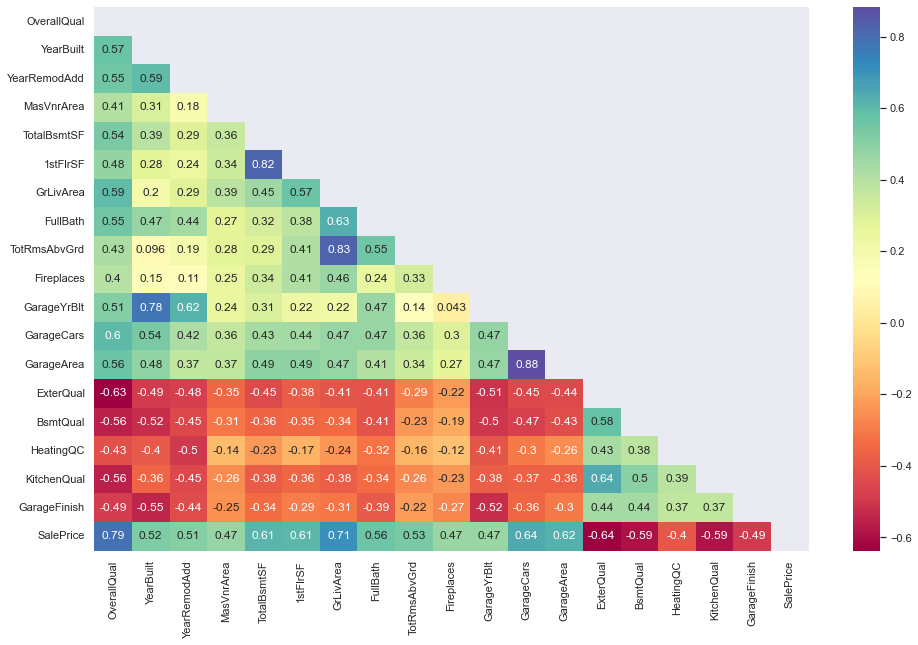

In [29]:
final_dataset = pd.concat([
    my_final_X,
    pd.DataFrame(
        Y,
        index=Y.index,
        columns=['SalePrice']
    )
],axis=1)

correlation = final_dataset.corr()
sns.set(rc = {'figure.figsize':(16,10)})
mask = np.triu(np.ones_like(correlation))
hmap = sns.heatmap(correlation, annot=True, mask=mask, cmap="Spectral")

- GarageArea and GarageCars feature are strongly positively correlated so I dropped GarageArea feature to avoid redundency and bias.  
- Same thing, 1stFlrSF and TotalBsmtSF features strongly positively correlated so I dropped TotalBsmtSF feature.  
- again same thing for TotRmsAbvGrd and GrLivArea, so I dropped TotRmsAbvGrd feature.

In [30]:
final_dataset = final_dataset.drop(['GarageArea','TotalBsmtSF', 'TotRmsAbvGrd'], axis=1)
test_my_final_X = test_my_final_X.drop(['GarageArea','TotalBsmtSF', 'TotRmsAbvGrd'], axis=1)
# test_my_final_X.info()

* I Scaled our X features in the training and testing sets using StandardScaler.

In [31]:
from sklearn.preprocessing import StandardScaler
Y = final_dataset['SalePrice']
final_dataset_X = final_dataset.drop(['SalePrice'], axis=1)

scaler = StandardScaler()
for i in final_dataset_X.columns:
    final_dataset_X[i] = scaler.fit_transform(final_dataset_X[[i]])

for i in test_my_final_X.columns:
    test_my_final_X[i] = scaler.fit_transform(test_my_final_X[[i]])

print(final_dataset_X.head(10))

   OverallQual  YearBuilt  YearRemodAdd  MasVnrArea  1stFlrSF  GrLivArea  \
0     0.651479   1.050994      0.878668    0.514104 -0.793434   0.370333   
1    -0.071836   0.156734     -0.429577   -0.570750  0.257140  -0.482512   
2     0.651479   0.984752      0.830215    0.325915 -0.627826   0.515013   
3     0.651479  -1.863632     -0.720298   -0.570750 -0.521734   0.383659   
4     1.374795   0.951632      0.733308    1.366489 -0.045611   1.299326   
5    -0.795151   0.719786      0.491040   -0.570750 -0.948691  -0.292145   
6     1.374795   1.084115      0.975575    0.458754  1.374993   0.339875   
7     0.651479   0.057371     -0.574938    0.757643 -0.143941   1.093729   
8     0.651479  -1.333700     -1.689368   -0.570750 -0.363889   0.492168   
9    -0.795151  -1.068734     -1.689368   -0.570750 -0.221569  -0.834691   

   FullBath  Fireplaces  GarageYrBlt  GarageCars  ExterQual  BsmtQual  \
0  0.789741   -0.951226     1.017598    0.311725  -0.777976 -0.297095   
1  0.789741    0.

### Fourth Step: Split Data, Train Model and Evaluate it 

* I splitted the training set to (train & validate)

In [32]:
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

def compute_rmsle(y_test: np.ndarray, y_pred: np.ndarray, precision: int = 2) -> float:
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    return round(rmsle, precision)

X_train, X_test, y_train, y_test = train_test_split(final_dataset_X, Y, test_size = 0.1, random_state = 0)

I defined a Lasso regression model and trained it and use it to predict.

In [33]:
from sklearn.linear_model import Lasso
Lasso = Lasso(alpha=2)


Lasso.fit(X_train, y_train)
y_pred = Lasso.predict(X_test)

compute_rmsle(y_test,y_pred)

0.17

* I used Random Forest regression model to test on it as well and compare wit hthe previous model.

In [34]:
from sklearn.ensemble import RandomForestRegressor

mod = RandomForestRegressor()
mod.fit(X_train,y_train)
y_pred = mod.predict(X_test)
compute_rmsle(y_test,y_pred)


0.13

* I thought of plotting SalePrice & OverallQual (because it is the most correlated feature with SalePrice), and I noticed a curve like parabola  
so I thought of fitting a polinomial regression model (because it is more flexible than linear single regression).  
but it didn't give good results!

In [35]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=2, include_bias=False)
x_poly_train = poly.fit_transform(X_train)
x_poly_test = poly.fit_transform(X_test)
model = LinearRegression()
model.fit(x_poly_train,y_train)
y_poly_pred = model.predict(x_poly_test)


x_poly_test_kaggle = poly.fit_transform(test_my_final_X)

compute_rmsle(y_test,y_poly_pred)


0.15

### Fifth Step: Submission File Preparation

* This cell just to prepare a submission file for Kaggle.

In [36]:
test_y_pred = model.predict(x_poly_test_kaggle)
Output = pd.DataFrame()
Output['Id'] = ids['Id']
Output['SalePrice'] = pd.DataFrame(test_y_pred, columns=['SalePrice'])
Output.to_csv('../submission_1.txt', index=False)